In [3]:
import numpy as np
from numpy import pi, log, sqrt
import time

import matplotlib.pyplot as plt
import scipy.special
from scipy.integrate import odeint
import getdist
from getdist import plots, MCSamples

import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, DotProduct, RBF, ConstantKernel,Matern

from scipy.optimize import minimize
import emcee

import scipy.optimize as op
from numpy.linalg import inv

91


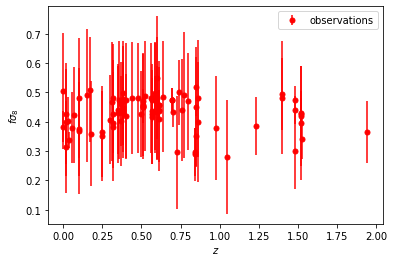

In [4]:
# read the fsigma8 data sets
fs8data = np.loadtxt('Growth.txt')
fs8data = fs8data[np.argsort(fs8data[:,0])]

z8Arr=fs8data[:,0]
fs8Arr=fs8data[:,1]
dfs8Arr=(fs8data[:,2]+fs8data[:,3])/2

plt.errorbar(z8Arr, fs8Arr, dfs8Arr, fmt='r.', markersize=10,label = 'observations')
plt.xlabel('$z$')
plt.ylabel('$f\sigma_8$')
plt.legend(loc='upper right')
plt.savefig('data.pdf')
print(len(z8Arr))

In [75]:
#Hypergeometric 2F1 Regularized
def reg(a,b,c,z):
    return scipy.special.hyp2f1(a,b,c,z)/scipy.special.gamma(c)

# return the f\sigma8 for a wCDM background model
def fsig8(theta,z):
    w,om,sig80 = theta
    aa = reg(3/2 - 1/(2*w),1-1/(3*w),(2-5/(6*w)),(om-1)/(om)*(1+z)**(3*w))
    bb = reg(-1/(3*w),(w-1)/(2*w),(1-5/(6*w)),(om-1)/(om)*(1+z)**(3*w))
    cc = reg(-1/(3*w),(w-1)/(2*w),(1-5/(6*w)),(om-1)/(om))
    dd = (z+1)**(3*w)*(w-1)*(om-1)/(2*w*om)
    return sig80/(1+z)*(aa*dd + bb)/cc

# return the f\sigma8 for a LCDM background model
def fsig8L(theta,z):
    om,sig80 = theta
    return fsig8([-1,om,sig80],z)

print(fsig8L([0.311, 0.811],0.86))

0.4464829301324176


In [76]:
# biuld the covariance matrix
def covFromErr(error):
    num = len(error)
    cov = np.zeros((num,num))
    for j in range(num):
        cov[j,j] = error[j]**2
    return inv(cov)

def randCov(list_length,error):
    num = len(error)
    cov = np.zeros((num,num))
    for j in range(num):
        cov[j,j] = error[j]**2
    # the covariance matrix for the uncorrelated data
    randomList = random.sample(range(len(error)), list_length)
    for i in range(len(randomList)):
        for j in range(len(randomList)):
            if (i!=j):
                cov[i,j] += 0.25*error[i]*error[j]               
    return inv(cov)

In [77]:
# likelihood with covariance matrix
def lnlike(theta,model,x,y,cov):
    chi2 = 0 
    prediction = []
    #x = x*np.ones(len(model))
    for i in range(len(x)):
        prediction.append(model(theta,x[i]))
    prediction = np.array(prediction)
    prediction.shape
    vec = (prediction - y)
    
    result = np.dot(np.dot(vec,cov),vec.T)
    return result

numUn = 10

print(lnlike([0.311, 0.811],fsig8L,z8Arr,fs8Arr,covFromErr(dfs8Arr)))
print(lnlike([-1,0.311, 0.811],fsig8,z8Arr,fs8Arr,covFromErr(dfs8Arr)))
print(lnlike([0.311, 0.811],fsig8L,z8Arr,fs8Arr,randCov(numUn,dfs8Arr)))
print(lnlike([-1,0.311, 0.811],fsig8,z8Arr,fs8Arr,randCov(numUn,dfs8Arr)))

41.30406734458533
41.30406734458533
42.22376480859725
42.22376480859725


In [78]:
def s8wfun(theta):
    w,om,sig80 = theta
    return sig80*np.sqrt(om/0.3)

def s8fun(theta):
    om,sig80 = theta
    return sig80*np.sqrt(om/0.3)

s8fun([0.311,0.811])

0.8257344831522218

In [79]:
nll = lambda *args: lnlike(*args)
result = op.minimize(nll, [0.31, 0.8], args=(fsig8L, fs8data[:,0], fs8data[:,1], covFromErr(fs8data[:,2])),bounds=((0.0001, 1.),(0.5, 1.5)))
resultw = op.minimize(nll, [-1,0.31, 0.8], args=(fsig8, fs8data[:,0], fs8data[:,1], covFromErr(fs8data[:,2])),bounds=((-2.5,-0.01),(0.0001, 1.),(0.5, 1.5)))

print(result)
print(resultw)

      fun: 50.784430715580946
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0004313 , 0.00031761])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 7
   status: 0
  success: True
        x: array([0.22345119, 0.83071325])
      fun: 49.75194866114046
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.42108547e-06, -4.05009359e-04, -1.70530257e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 16
   status: 0
  success: True
        x: array([-0.81980188,  0.21612049,  0.882369  ])


In [80]:
nll = lambda *args: lnlike(*args)
resultRan = op.minimize(nll, [0.31, 0.8], args=(fsig8L, fs8data[:,0], fs8data[:,1], randCov(numUn,dfs8Arr)),bounds=((0.0001, 1.),(0.5, 1.5)))
resultwRan = op.minimize(nll, [-1,0.31, 0.8], args=(fsig8, fs8data[:,0], fs8data[:,1], randCov(numUn,dfs8Arr)),bounds=((-2.5,-0.01),(0.0001, 1.),(0.5, 1.5)))

print(resultRan)
print(resultwRan)

      fun: 22.726255249537164
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.98427949e-05, -5.68434189e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 9
   status: 0
  success: True
        x: array([0.1903452 , 0.86358163])
      fun: 22.70602854841521
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.77635684e-06,  4.79616347e-05,  2.34479103e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 14
   status: 0
  success: True
        x: array([-0.96852472,  0.19066986,  0.87095488])


In [81]:
def lnprior(theta):
    if(len(theta) == 2):
        om, sig8 = theta
        if 0. < om <= 0.5 and 0.5 <= sig8 <= 1.2:
                 return 0. 
        return -np.inf
    
    if(len(theta) == 3):
        w, om, sig8 = theta
        if 0. < om <= 0.5 and 0.5 <= sig8 <= 1.2 and -1.5<= w <= -0.5:
                    return 0. 
        return -np.inf
        

def lnprob(theta, model, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - lnlike(theta, model, x, y, yerr)

runs = 3000

lnprob([0.27321688,0.78176077],fsig8L, fs8data[:,0], fs8data[:,1], randCov(numUn,dfs8Arr))

-31.507276823008695

In [82]:
nwalkers = 30
pos = [result["x"] + 1e-3*np.random.randn(2) for i in range(nwalkers)]
posw = [resultw["x"] + 1e-3*np.random.randn(3) for i in range(nwalkers)]

posTest = [result["x"] + 1e-3*np.random.randn(2) for i in range(nwalkers)]
poswTest = [resultw["x"] + 1e-3*np.random.randn(3) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, 2, lnprob, args=(fsig8L,fs8data[:,0],fs8data[:,1],covFromErr(dfs8Arr)))
samplerTest = emcee.EnsembleSampler(nwalkers, 2, lnprob, args=(fsig8L,fs8data[:,0],fs8data[:,1],randCov(numUn,dfs8Arr)))

samplerw = emcee.EnsembleSampler(nwalkers, 3, lnprob, args=(fsig8,fs8data[:,0],fs8data[:,1],covFromErr(dfs8Arr)))
samplerwTest = emcee.EnsembleSampler(nwalkers, 3, lnprob, args=(fsig8,fs8data[:,0],fs8data[:,1],randCov(numUn,dfs8Arr)))

sampler.run_mcmc(pos, runs,progress=True);
samplerw.run_mcmc(posw, runs,progress=True);
samplerTest.run_mcmc(posTest, runs,progress=True);
samplerwTest.run_mcmc(poswTest, runs,progress=True);

100%|██████████| 3000/3000 [04:52<00:00, 10.26it/s]


In [83]:
samples = sampler.chain[:].reshape((-1, 2))
samplesw = samplerw.chain[:].reshape((-1, 3))

In [84]:
samplerTest = samplerTest.chain[:].reshape((-1, 2))
samplerwTest = samplerwTest.chain[:].reshape((-1, 3))

Removed no burn in
Removed no burn in


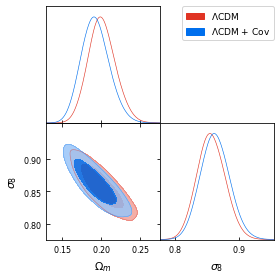

In [85]:
g = plots.get_subplot_plotter()
samples = MCSamples(samples=samples,names=['om','sig'], labels=[r'\Omega_m',r'\sigma_8'])
samplerTest = MCSamples(samples=samplerTest,names=['om','sig'], labels=[r'\Omega_m',r'\sigma_8'])

g.settings.legend_fontsize = 12
g.triangle_plot([samples,samplerTest],['om','sig'] ,filled=True, legend_labels=[r'$\Lambda$CDM',r'$\Lambda$CDM + Cov'])

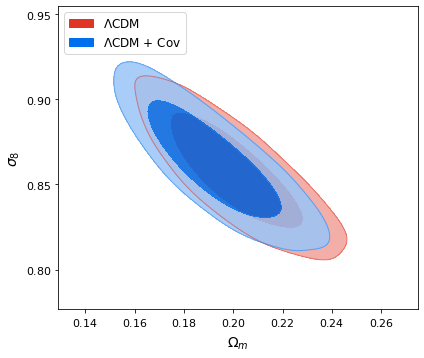

In [86]:
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([samples,samplerTest], ('om','sig'),filled=True)#colors=['gray', 'red'])
g.add_legend([r'$\Lambda$CDM',r'$\Lambda$CDM + Cov'], legend_loc='upper left');
g.export('BaseLCDM.pdf')

Removed no burn in
Removed no burn in


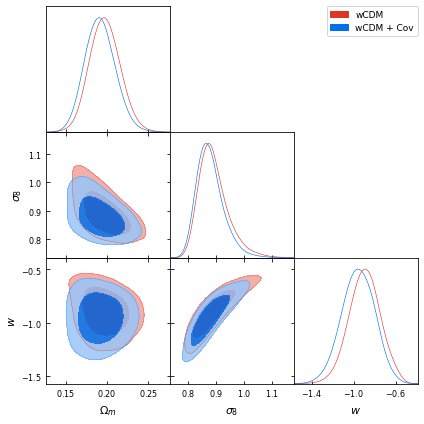

In [87]:
g = plots.get_subplot_plotter()
samplesw = MCSamples(samples=samplesw,names=['w','om','sig'], labels=['w',r'\Omega_m',r'\sigma_8'])
samplerwTest = MCSamples(samples=samplerwTest,names=['w','om','sig'], labels=['w',r'\Omega_m',r'\sigma_8'])

g.settings.legend_fontsize = 12
g.triangle_plot([samplesw,samplerwTest],['om','sig','w'] ,filled=True, legend_labels=[r'wCDM',r'wCDM + Cov'])

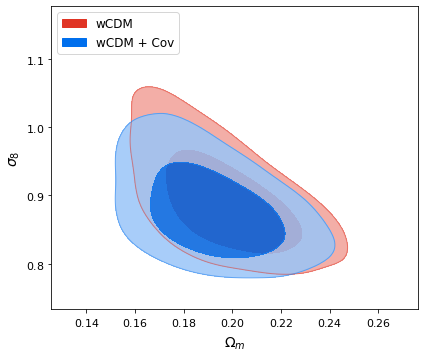

In [88]:
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([samplesw,samplerwTest], ('om','sig'),filled=True)#colors=['gray', 'red'])
g.add_legend([r'wCDM',r'wCDM + Cov'], legend_loc='upper left');
g.export('BasewCDM.pdf')

In [89]:
p = samples.getParams()
samples.addDerived(s8fun([p.om,p.sig]), name='s8', label='S_8')

In [90]:
q = samplerTest.getParams()
samplerTest.addDerived(s8fun([q.om,q.sig]), name='s8', label='S_8')
a = samplesw.getParams()
samplesw.addDerived(s8wfun([a.w,a.om,a.sig]), name='s8', label='S_8')
b = samplerwTest.getParams()
samplerwTest.addDerived(s8wfun([b.w,b.om,b.sig]), name='s8', label='S_8')

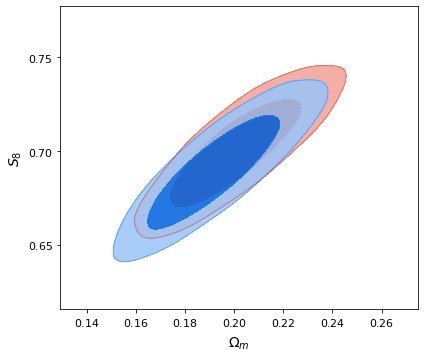

In [118]:
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([samples,samplerTest], ('om','s8'),filled=True)#colors=['gray', 'red'])
#g.add_legend([r'$\Lambda$CDM',r'$\Lambda$CDM + Cov'], legend_loc='upper left');
g.export('BaseSLCDM.pdf')

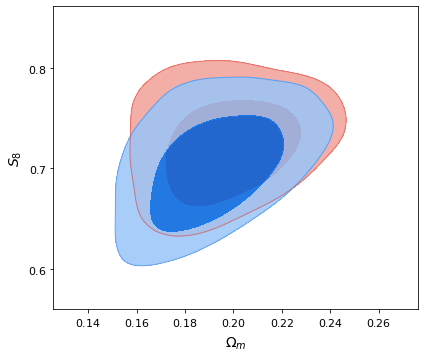

In [119]:
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([samplesw,samplerwTest], ('om','s8'),filled=True)#colors=['gray', 'red'])
#g.add_legend([r'$\Lambda$CDM',r'$\Lambda$CDM + Cov'], legend_loc='upper left');
g.export('BaseSwCDM.pdf')

In [91]:
print(samples.getTable().tableTex())
print(samplesw.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.201^{+0.036}_{-0.033}   $\\

{\boldmath$\sigma_8       $} & $0.857^{+0.044}_{-0.042}   $\\

$S_8                       $ & $0.700^{+0.038}_{-0.037}   $\\
\hline
\end{tabular}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$w              $} & $-0.90^{+0.29}_{-0.30}     $\\

{\boldmath$\Omega_m       $} & $0.198^{+0.038}_{-0.035}   $\\

{\boldmath$\sigma_8       $} & $0.891^{+0.11}_{-0.095}    $\\

$S_8                       $ & $0.722^{+0.072}_{-0.067}   $\\
\hline
\end{tabular}


In [92]:
print(samplerTest.getTable().tableTex())
print(samplerwTest.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.192^{+0.037}_{-0.033}   $\\

{\boldmath$\sigma_8       $} & $0.863^{+0.046}_{-0.043}   $\\

$S_8                       $ & $0.690^{+0.040}_{-0.038}   $\\
\hline
\end{tabular}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$w              $} & $-0.96^{+0.30}_{-0.31}     $\\

{\boldmath$\Omega_m       $} & $0.192^{+0.038}_{-0.034}   $\\

{\boldmath$\sigma_8       $} & $0.879^{+0.10}_{-0.088}    $\\

$S_8                       $ & $0.701^{+0.077}_{-0.074}   $\\
\hline
\end{tabular}


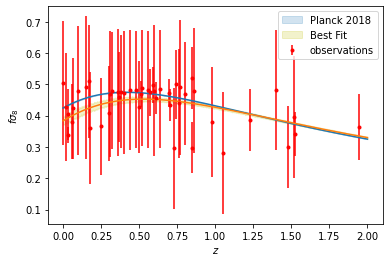

In [64]:
# Planck Prediction
omPl = 0.311; domPl = 0.007
sim8Pl = 0.811; dsim8Pl = 0.006

ndim = 10**2
varPl = np.zeros(ndim)

zz = np.linspace(0, 2, 1000)
fs8Plarr = np.zeros(len(zz)); dfs8Plarr = np.zeros(len(zz));
j = 0

while j < len(zz): 
    fs8Plarr[j] = fsig8([-1,omPl,sim8Pl],zz[j])
    
    for i in range(ndim):
        varPl[i] = fsig8([-1,np.random.normal(omPl,domPl),np.random.normal(sim8Pl,dsim8Pl)],zz[j])
    
    dfs8Plarr[j] = np.var(varPl[:])
    j += 1

fs8fit = np.zeros(len(zz)); dfs8fitarr = np.zeros(len(zz));   
j = 0

while j < len(zz): 
    fs8fit[j] = fsig8([-1,result["x"][0],result["x"][1]],zz[j])
    
    for i in range(ndim):
        varPl[i] = fsig8([-1,np.random.normal(result["x"][0],+0.055),np.random.normal(result["x"][1],+0.055)],zz[j])
    
    dfs8fitarr[j] = np.var(varPl[:])
    j += 1


fig, ax = plt.subplots()
ax.errorbar(z8Arr, fs8Arr, dfs8Arr, fmt='r.',label = 'observations')
ax.plot(zz, fs8Plarr, '-')
ax.fill_between(zz, fs8Plarr + 5*dfs8Plarr,fs8Plarr - 5*dfs8Plarr , alpha=0.2,color='C0',label = 'Planck 2018')
ax.plot(zz, fs8fit, '-')
ax.fill_between(zz, fs8fit + 5*dfs8fitarr,fs8fit - 5*dfs8fitarr , alpha=0.2 ,color='Y' ,label = 'Best Fit')
plt.xlabel('$z$')
plt.ylabel('$f\sigma_8$')
plt.legend(loc='upper right')
plt.savefig('dataPlanck.pdf')

In [65]:
#Calculating the Tension
def Ten(ha,hb,siga,sigb):
    return np.abs(ha-hb)/np.sqrt(siga**2 + sigb**2)

print(Ten(0.82210296,0.811,0.055,0.006))
print(Ten(0.2306885,0.315,0.055,0.058))
#wCDM
print(Ten(-0.63111201,-1.03,0.055,0.03))

0.200681394596209
1.0548006091070528
6.366945463813042


In [66]:
# Instantiate a Gaussian Process model
np.random.seed(60)
zz = np.linspace(0, 2, 100)

kernel1 = ConstantKernel(0.1, (0.01, 10.0))* RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
kernel2 = Matern(length_scale=1.0, length_scale_bounds=(1e-5, 4.0),nu=3.5)
kernel3 = Matern(length_scale=1.0, length_scale_bounds=(5, 100.0),nu=4.5)

gp1 = GaussianProcessRegressor(kernel=kernel1,alpha = dfs8Arr**2,n_restarts_optimizer=10)
gp2 = GaussianProcessRegressor(kernel=kernel2,alpha = dfs8Arr**2,n_restarts_optimizer=10)
gp3 = GaussianProcessRegressor(kernel=kernel3,alpha = dfs8Arr**2/2,n_restarts_optimizer=10)


# Fit to data using Maximum Likelihood Estimation of the parameters
gp1.fit(z8Arr.reshape(-1,1) ,fs8Arr.reshape(-1,1)) 
gp2.fit(z8Arr.reshape(-1,1) ,fs8Arr.reshape(-1,1)) 
gp3.fit(z8Arr.reshape(-1,1) ,fs8Arr.reshape(-1,1)) 


fs8Arr_pred1, sigma_pred1 = gp1.predict(zz.reshape(-1, 1), return_std=True) 
fs8Arr_pred2, sigma_pred2 = gp2.predict(zz.reshape(-1, 1), return_std=True) 
fs8Arr_pred3, sigma_pred3 = gp3.predict(zz.reshape(-1, 1), return_std=True) 

fs8Arr_predpar1, sigma_predpar1 = gp1.predict(z8Arr.reshape(-1, 1), return_std=True) 
fs8Arr_predpar2, sigma_predpar2 = gp2.predict(z8Arr.reshape(-1, 1), return_std=True) 
fs8Arr_predpar3, sigma_predpar3 = gp3.predict(z8Arr.reshape(-1, 1), return_std=True) 

print(fs8Arr_pred1[0,0], sigma_pred1[0])
print(fs8Arr_pred2[0,0], sigma_pred2[0])
print(fs8Arr_pred3[0,0], sigma_pred3[0])

/home/benidav/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.3576537940391844 0.02413507168447209
0.35571019217951116 0.025031528980235324
0.3722690565807891 0.01666109583372289


/home/benidav/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


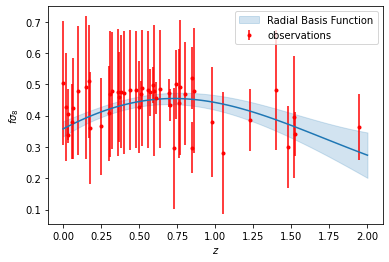

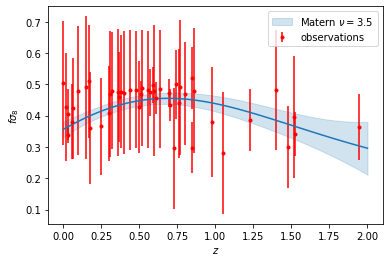

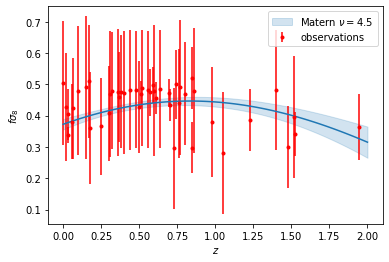

In [67]:
zz = np.linspace(0, 2, 100)
fig, ax = plt.subplots()
ax.plot(zz, fs8Arr_pred1)
ax.fill_between(zz, fs8Arr_pred1[:,0] + sigma_pred1,fs8Arr_pred1[:,0] - sigma_pred1, alpha=0.2,color='C0',label = 'Radial Basis Function')
ax.errorbar(z8Arr, fs8Arr, dfs8Arr, fmt='r.',label = 'observations')
plt.xlabel('$z$')
plt.ylabel('$f\sigma_8$')
plt.legend(loc='upper right')
plt.savefig('GPRBF.pdf')

fig, ax = plt.subplots()
ax.plot(zz, fs8Arr_pred2)
ax.fill_between(zz, fs8Arr_pred2[:,0] + sigma_pred2,fs8Arr_pred2[:,0] - sigma_pred2, alpha=0.2,color='C0',label = r'Matern $\nu = 3.5$')
ax.errorbar(z8Arr, fs8Arr, dfs8Arr, fmt='r.',label = 'observations')
plt.xlabel('$z$')
plt.ylabel('$f\sigma_8$')
plt.legend(loc='upper right')
plt.savefig('GPMatern3.pdf')

fig, ax = plt.subplots()
ax.plot(zz, fs8Arr_pred3)
ax.fill_between(zz, fs8Arr_pred3[:,0] + sigma_pred3,fs8Arr_pred3[:,0] - sigma_pred3, alpha=0.2,color='C0',label = r'Matern $\nu = 4.5$')
ax.errorbar(z8Arr, fs8Arr, dfs8Arr, fmt='r.',label = 'observations')
plt.xlabel('$z$')
plt.ylabel('$f\sigma_8$')
plt.legend(loc='upper right')
plt.savefig('GPMatern4.pdf')

In [68]:
def fracOm(om):
    return (om-1)/om

def fit(theta):
    om, sig8 = theta
    return sig8*(1 + 6/11* fracOm(om)*scipy.special.hyp2f1(4/3,2,17/6,fracOm(om))/scipy.special.hyp2f1(1/3,1,11/6,fracOm(om))) 

def chi2(theta,y,yerr):
    om, sig8 = theta
    return -0.5*((fit(theta) - y)/yerr)**2  

def chi2w(theta,y,yerr):
    w, om, sig8 = theta
    return -0.5*((fitw(theta) - y)/yerr)**2  

def fitw(theta):
    w, om, sig8 = theta
    aa = scipy.special.hyp2f1(1/2 - 1/(2*w),-1/(3*w),1-5/(6*w),fracOm(om))
    bb = (1/2 - 1/(2*w))*(fracOm(om))/(1-5/(6*w))*scipy.special.hyp2f1(3/2 - 1/(2*w),1-1/(3*w),2-5/(6*w),fracOm(om))
    cc = scipy.special.hyp2f1(1/2 - 1/(2*w),-1/(3*w),1-5/(6*w),fracOm(om))    
    return sig8*(aa+bb)/cc 

chi2w([-1,0.31,0.78],fs8Arr_pred2[0,0],sigma_pred2[0])
#fitw([-1,0.31,0.8])

-2.1361099528308447

In [69]:
import scipy.optimize as op
nll = lambda *args: -chi2(*args)
nllw = lambda *args: -chi2w(*args)

bnds = ((0.2, 0.35), (0.5, 1.))
bndsw = ((-1.5,-0.5), (0.2, 0.35), (0.5, 1.))

result1 = op.minimize(nll, [0.3,0.8], args=(fs8Arr_pred1[0,0], sigma_pred1[0]),bounds=bnds)
result2 = op.minimize(nll, [0.3,0.8], args=(fs8Arr_pred2[0,0], sigma_pred2[0]),bounds=bnds)
result3 = op.minimize(nll, [0.3,0.8], args=(fs8Arr_pred3[0,0], sigma_pred3[0]),bounds=bnds)

resultw1 = op.minimize(nllw, [-1,0.3,0.8], args=(fs8Arr_pred1[0,0], sigma_pred1[0]),bounds=bndsw)
resultw2 = op.minimize(nllw, [-1,0.3,0.8], args=(fs8Arr_pred2[0,0], sigma_pred2[0]),bounds=bndsw)
resultw3 = op.minimize(nllw, [-1,0.3,0.8], args=(fs8Arr_pred3[0,0], sigma_pred3[0]),bounds=bndsw)


print(result1["x"])
print(result2["x"])
print(result3["x"])
print(resultw1["x"])
print(resultw2["x"])
print(resultw3["x"])

[0.27669147 0.73007365]
[0.27580756 0.72742188]
[0.28328477 0.74985377]
[-0.88749343  0.27749936  0.73249676]
[-0.88323604  0.27664791  0.72994235]
[-0.91927168  0.28385478  0.75156347]


In [70]:
def lnprior(theta):
    om, sig8 = theta
    if 0.1 <= om <= 0.4  and 0.6 <= sig8 <= 1.:
        return 0 
    return -np.inf

def lnpost(theta, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi2(theta, y, yerr)

def lnpriorw(theta):
    w, om, sig8 = theta
    if  -1.5 <= w <=-0.5 and 0.1 <= om <= 0.4  and 0.6 <= sig8 <= 1.:
        return 0 
    return -np.inf

def lnpostw(theta, y, yerr):
    lp = lnpriorw(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi2w(theta, y, yerr)

lnpostw([-1,0.3,0.79986183], fs8Arr_pred2[0,0], sigma_pred2[0])

-2.366388101017051

In [71]:
ndim, nwalkers = 2, 10
pos1 = [result1["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
pos2 = [result2["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
pos3 = [result3["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

posw1 = [resultw1["x"] + 1e-4*np.random.randn(3) for i in range(nwalkers)]
posw2 = [resultw2["x"] + 1e-4*np.random.randn(3) for i in range(nwalkers)]
posw3 = [resultw3["x"] + 1e-4*np.random.randn(3) for i in range(nwalkers)]

import emcee
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(fs8Arr_pred1[0,0], sigma_pred1[0]))
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(fs8Arr_pred2[0,0], sigma_pred2[0]))
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(fs8Arr_pred3[0,0], sigma_pred3[0]))

samplerw1 = emcee.EnsembleSampler(nwalkers, 3, lnpostw, args=(fs8Arr_pred1[0,0], sigma_pred1[0]))
samplerw2 = emcee.EnsembleSampler(nwalkers, 3, lnpostw, args=(fs8Arr_pred2[0,0], sigma_pred2[0]))
samplerw3 = emcee.EnsembleSampler(nwalkers, 3, lnpostw, args=(fs8Arr_pred3[0,0], sigma_pred3[0]))

sampler1.run_mcmc(pos1, runs,progress=True);
sampler2.run_mcmc(pos2, runs,progress=True);
sampler3.run_mcmc(pos3, runs,progress=True);

samplerw1.run_mcmc(posw1, runs,progress=True);
samplerw2.run_mcmc(posw2, runs,progress=True);
samplerw3.run_mcmc(posw3, runs,progress=True);

100%|██████████| 3000/3000 [00:02<00:00, 1203.17it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 432x324 with 0 Axes>

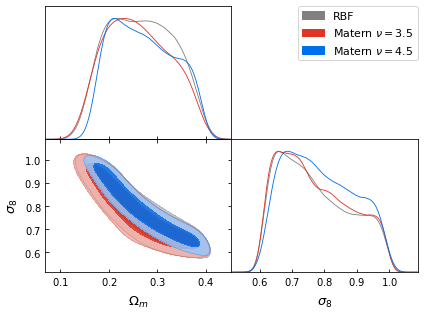

<Figure size 432x324 with 0 Axes>

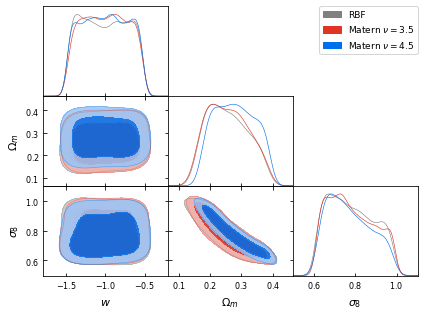

In [97]:
samples1 = sampler1.chain[:].reshape((-1, ndim))
samples2 = sampler2.chain[:].reshape((-1, ndim))
samples3 = sampler3.chain[:].reshape((-1, ndim))

samplesw1 = samplerw1.chain[:].reshape((-1, 3))
samplesw2 = samplerw2.chain[:].reshape((-1, 3))
samplesw3 = samplerw3.chain[:].reshape((-1, 3))

samples1 = MCSamples(samples=samples1,names=['om','sig8'], labels=[r'\Omega_m',r'\sigma_8'])
samples2 = MCSamples(samples=samples2,names=['om','sig8'], labels=[r'\Omega_m',r'\sigma_8'])
samples3 = MCSamples(samples=samples3,names=['om','sig8'], labels=[r'\Omega_m',r'\sigma_8'])

samplesw1 = MCSamples(samples=samplesw1,names=['w','om','sig8'], labels=['w',r'\Omega_m',r'\sigma_8'])
samplesw2 = MCSamples(samples=samplesw2,names=['w','om','sig8'], labels=['w',r'\Omega_m',r'\sigma_8'])
samplesw3 = MCSamples(samples=samplesw3,names=['w','om','sig8'], labels=['w',r'\Omega_m',r'\sigma_8'])


g = plots.get_single_plotter()
g.settings.legend_fontsize = 12
g.triangle_plot([samples1,samples2,samples3],['om','sig8'],filled=True,legend_labels=['RBF',r'Matern $\nu = 3.5$',r'Matern $\nu = 4.5$'])

g = plots.get_single_plotter()
g.settings.legend_fontsize = 12
g.triangle_plot([samplesw1,samplesw2,samplesw3],['w','om','sig8'],filled=True,legend_labels=['RBF',r'Matern $\nu = 3.5$',r'Matern $\nu = 4.5$'])


In [98]:
q = samples1.getParams()
samples1.addDerived(s8fun([q.om,q.sig8]), name='s8', label='S_8')
q = samples2.getParams()
samples2.addDerived(s8fun([q.om,q.sig8]), name='s8', label='S_8')
q = samples3.getParams()
samples3.addDerived(s8fun([q.om,q.sig8]), name='s8', label='S_8')

In [99]:
q = samplesw1.getParams()
samplesw1.addDerived(s8fun([q.om,q.sig8]), name='s8', label='S_8')
q = samplesw2.getParams()
samplesw2.addDerived(s8fun([q.om,q.sig8]), name='s8', label='S_8')
q = samplesw3.getParams()
samplesw3.addDerived(s8fun([q.om,q.sig8]), name='s8', label='S_8')

In [100]:
print(samples1.getTable().tableTex())
print(samples2.getTable().tableTex())
print(samples3.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.27^{+0.12}_{-0.11}      $\\

{\boldmath$\sigma_8       $} & $0.77^{+0.21}_{-0.16}      $\\

$S_8                       $ & $0.707^{+0.085}_{-0.085}   $\\
\hline
\end{tabular}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.26^{+0.13}_{-0.11}      $\\

{\boldmath$\sigma_8       $} & $0.77^{+0.21}_{-0.16}      $\\

$S_8                       $ & $0.701^{+0.089}_{-0.089}   $\\
\hline
\end{tabular}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.27^{+0.12}_{-0.10}      $\\

{\boldmath$\sigma_8       $} & $0.79^{+0.19}_{-0.17}      $\\

$S_8                       $ & $0.731^{+0.063}_{-0.062}   $\\
\hline
\end{tabular}


In [101]:
print(samplesw1.getTable().tableTex())
print(samplesw2.getTable().tableTex())
print(samplesw3.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$w              $} & $-1.01^{+0.48}_{-0.47}     $\\

{\boldmath$\Omega_m       $} & $0.26^{+0.12}_{-0.11}      $\\

{\boldmath$\sigma_8       $} & $0.78^{+0.20}_{-0.17}      $\\

$S_8                       $ & $0.704^{+0.087}_{-0.082}   $\\
\hline
\end{tabular}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$w              $} & $-0.998^{+0.47}_{-0.47}    $\\

{\boldmath$\Omega_m       $} & $0.26^{+0.12}_{-0.11}      $\\

{\boldmath$\sigma_8       $} & $0.78^{+0.20}_{-0.17}      $\\

$S_8                       $ & $0.706^{+0.098}_{-0.092}   $\\
\hline
\end{tabular}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$w              $} & $-1.00^{+0.47}_{-0.48}     $\\

{\boldmath$\Omega_m       $} & $0.28^{+0.11}_{-0.11}      $\\

{\boldmath$\sigma_8       $} & $0.77^{+0.20}_{-0.16}      $\\

$S_8                       $ & $0.730^{+0.067}_{-0.063}   $\\
\hline
\end{tabular}


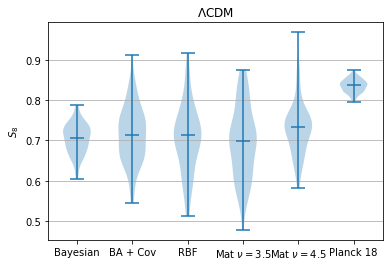

In [9]:
# if using a Jupyter notebook, include:
%matplotlib inline

# generate some random data
data1 = np.random.normal(0.700, 0.038, 100)
data2 = np.random.normal(0.722, 0.072, 100)
data3 = np.random.normal(0.707, 0.085, 100)
data4 = np.random.normal(0.701, 0.089, 100)
data5 = np.random.normal(0.731, 0.063, 100)
data6 = np.random.normal(0.834, 0.016, 100)

data = list([data1, data2, data3, data4, data5 ,data6])

fig, ax = plt.subplots()


# build a violin plot
ax.violinplot(data, showmeans=False, showmedians=True)


# add title and axis labels
ax.set_title('$\Lambda$CDM')
#ax.set_xlabel('x-axis')
ax.set_ylabel('$S_8$')


# add x-tick labels
xticklabels = ['Bayesian', 'BA + Cov', 'RBF',r'Mat $\nu = 3.5$',r'Mat $\nu = 4.5$',r'Planck 18']

ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(xticklabels)


# add horizontal grid lines
ax.yaxis.grid(True)

plt.savefig('S8LCDM.pdf')
# show the plot
plt.show()

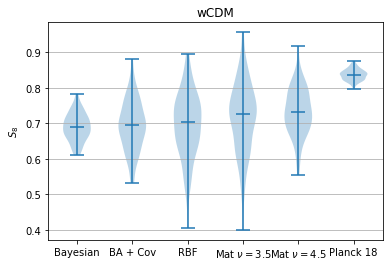

In [116]:
# if using a Jupyter notebook, include:
%matplotlib inline

# generate some random data
data1 = np.random.normal(0.690, 0.040, 100)
data2 = np.random.normal(0.701, 0.077, 100)
data3 = np.random.normal(0.704, 0.087, 100)
data4 = np.random.normal(0.706, 0.098, 100)
data5 = np.random.normal(0.730, 0.067, 100)
data6 = np.random.normal(0.834, 0.016, 100)

data = list([data1, data2, data3, data4, data5, data6])

fig, ax = plt.subplots()


# build a violin plot
ax.violinplot(data, showmeans=False, showmedians=True)


# add title and axis labels
ax.set_title('wCDM')
#ax.set_xlabel('x-axis')
ax.set_ylabel('$S_8$')


# add x-tick labels
xticklabels = ['Bayesian', 'BA + Cov', 'RBF',r'Mat $\nu = 3.5$',r'Mat $\nu = 4.5$',r'Planck 18']
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(xticklabels)


# add horizontal grid lines
ax.yaxis.grid(True)

plt.savefig('S8wCDM.pdf')
# show the plot
plt.show()

In [8]:
def T(ha,hb,siga,sigb):
    return np.abs(ha-hb)/np.sqrt(siga**2 + sigb**2)

def Tpl(h,sig):
    return T(h,0.834,sig,0.016)

#Planck 0.834 0.016
print(Tpl(0.700,0.038))
print(Tpl(0.722,0.072))
print(Tpl(0.707,0.085))
print(Tpl(0.701,0.089))
print(Tpl(0.731,0.063))
#wCDM
print(Tpl(0.704,0.087))
print(Tpl(0.706,0.098))
print(Tpl(0.730,0.067))

3.2499773754868624
1.5185132047305931
1.4683307487787334
1.4708034574074247
1.5846153846153843
1.469606889254976
1.2890551912172175
1.5097854333628071
